In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
%matplotlib inline

In [73]:
df = pd.read_csv('./data/train.csv')

In [74]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [169]:
def data_preprocessing(df):
    df1 = df.copy()
    null_counts = df1.isnull().sum()/len(df1)
    drop_columns = (null_counts[null_counts > 0.85]).index # columns with more than 80% missing values
    df1.drop(drop_columns, axis=1, inplace=True)
    
    #Imputing missing values for LotFrontage
    meadian_lotfrontage = df1.groupby('Neighborhood')['LotFrontage'].median()
    df1.fillna({'LotFrontage': df1['Neighborhood'].map(meadian_lotfrontage)}, inplace=True)
    
    #Imputing missing values for MasVnrType
    df1['MasVnrType'].fillna('None', inplace=True)
    
    #Imputing missing values for MasVnrArea
    df1['MasVnrArea'].fillna(0, inplace=True)
    
    #Imputing missing values for BsmtQual
    df1['BsmtQual'].fillna('NA', inplace=True)
    
    #Imputing missing values for BsmtCond
    df1['BsmtCond'].fillna('NA', inplace=True)
    
    #Imputing missing values for BsmtExposure
    df1['BsmtExposure'].fillna('NA', inplace=True)
    
    #Imputing missing values for BsmtFinType1 & BsmtFinType2
    df1['BsmtFinType1'].fillna('NA', inplace=True)
    df1['BsmtFinType2'].fillna('NA', inplace=True)
    
    #Imputing missing values for Electrical
    df1['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)
    
    #Imputing missing values for FireplaceQu
    df1['FireplaceQu'].fillna('NA', inplace=True)
    
    #Imputing missing values for Fence
    df1['Fence'].fillna('NA', inplace=True)
    
    #Imputing missing values for GarageType, GarageFinish, GarageCond, GarageQual
    df1['GarageType'].fillna('NA', inplace=True)
    df1['GarageFinish'].fillna('NA', inplace=True)
    df1['GarageCond'].fillna('NA', inplace=True)
    df1['GarageQual'].fillna('NA', inplace=True)
    df1['GarageYrBlt'].fillna(df1['YearBuilt'], inplace=True)
    
    
    #Dropping the columns which are just one value
    columns_to_drop = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', '3SsnPorch', 'PoolArea', 'MiscVal']
    df1.drop(columns_to_drop, axis=1, inplace=True)
    
    
    # Creating new features
    df1['Age'] = df1['YrSold'] - df1['YearBuilt']
    df1['RemodAge'] = df1['YrSold'] - df1['YearRemodAdd']
    df1['GarageAge'] = df1['YrSold'] - df1['GarageYrBlt']
    df1['TotalSF'] = df1['TotalBsmtSF'] + df1['1stFlrSF'] + df1['2ndFlrSF']
    df1['TotalBsmtFin'] = df1['BsmtFinSF1'] + df1['BsmtFinSF2']
    df1['TotalBath'] = df1['FullBath'] + 0.5*df1['HalfBath'] + df1['BsmtFullBath'] + 0.5*df1['BsmtHalfBath']
    df1['TotalPorchSF'] = df1['OpenPorchSF'] + df1['EnclosedPorch'] + df1['ScreenPorch'] + df1['WoodDeckSF']
    
    
    finish_type_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1,'NA': 0}
    exposure_map = {'Gd': 4,'Av': 3,'Mn': 2,'No': 1,'NA': 0}
    condition_map = {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'NA': 0}
    fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}
    garage_finish_map = {'Fin': 3,'RFn': 2,'Unf': 1,'NA': 0}

    ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
    for col in ord_col:
        df1[col] = df1[col].map(condition_map)
    
    fin_col = ['BsmtFinType1','BsmtFinType2']
    for col in fin_col:
        df1[col] = df1[col].map(finish_type_map)

    df1['BsmtExposure'] = df1['BsmtExposure'].map(exposure_map)
    df1['Fence'] = df1['Fence'].map(fence_map)
    df1['GarageFinish'] = df1['GarageFinish'].map(garage_finish_map)
    
    y = np.log1p(df1['SalePrice'])
    
    features_drop = ['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'OpenPorchSF', 'EnclosedPorch', 
                     'ScreenPorch', 'WoodDeckSF', 'SalePrice', 'Id', 'GarageArea']
    
    df1.drop(features_drop, axis=1, inplace=True)
    
    nominal_columns = df1.columns[df1.dtypes == 'object']
    df1 = pd.get_dummies(df1, columns=nominal_columns, drop_first=True)
    df1 = df1.astype({col: int for col in df1.select_dtypes(include=['bool']).columns})
    X = df1.values
    
    
    
    return X, y

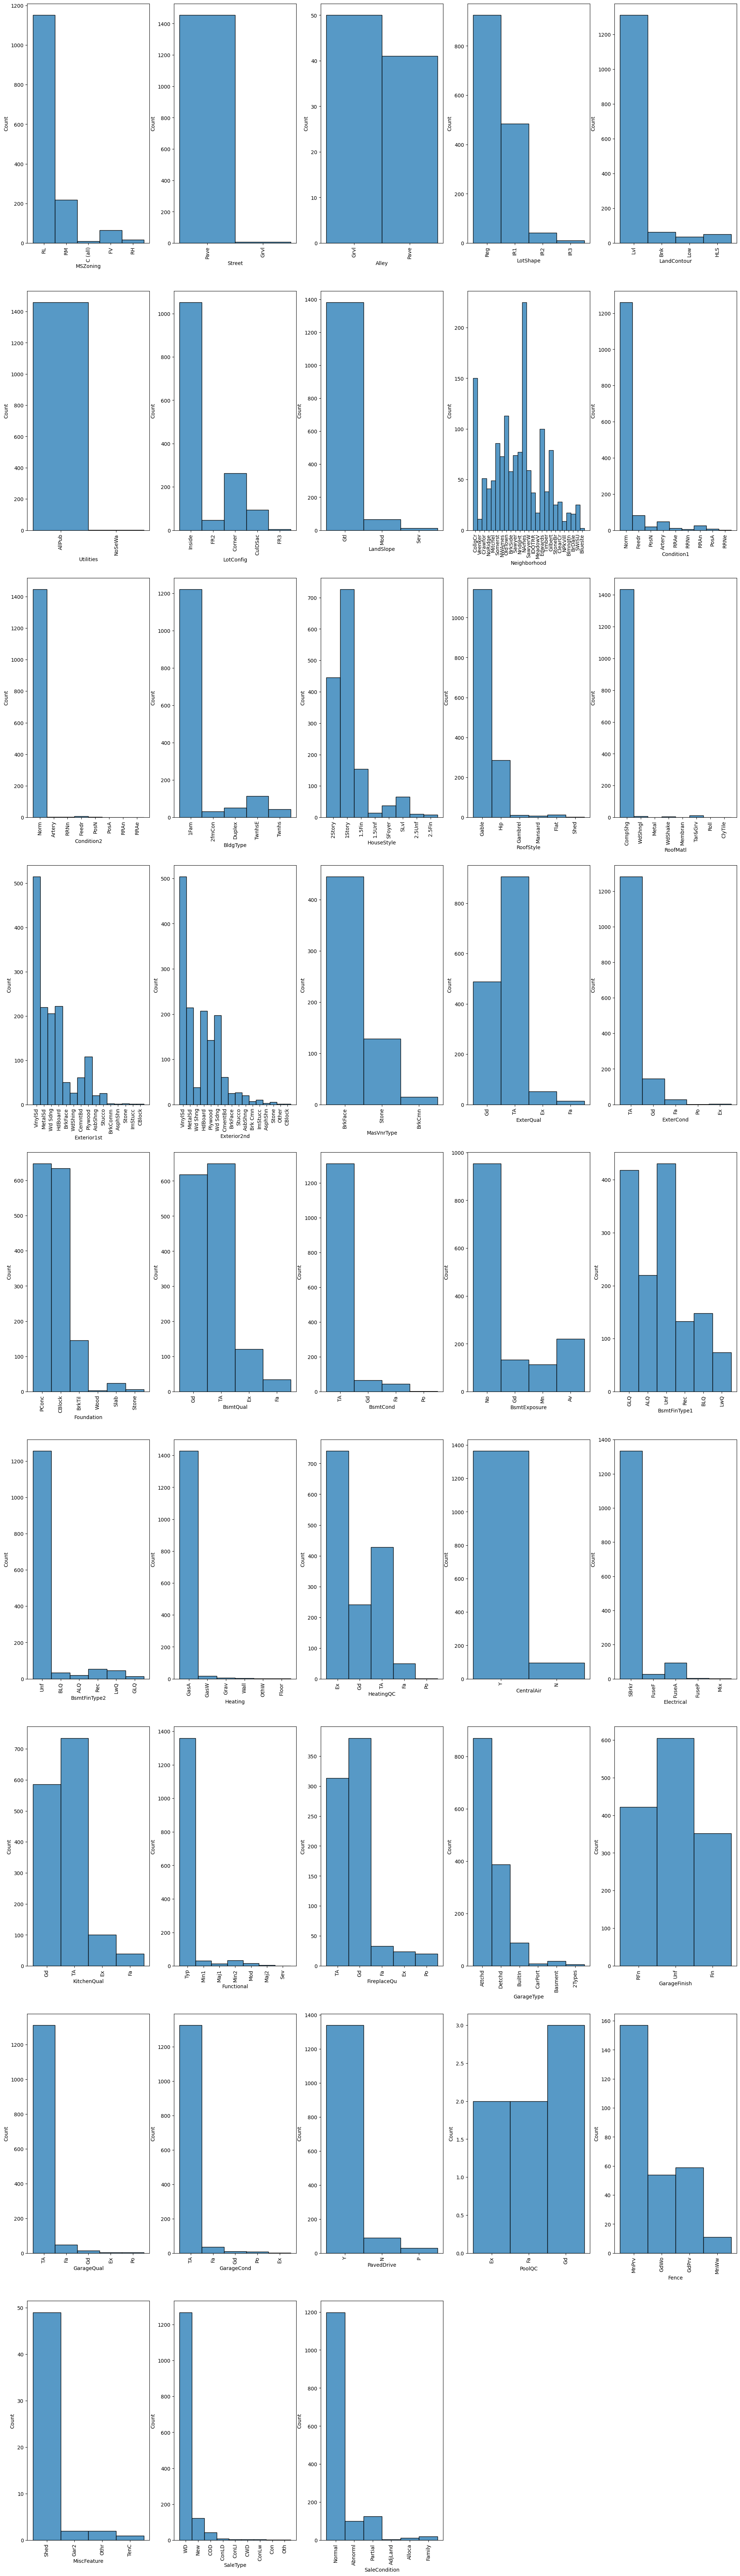

In [83]:
num_cols = len(df.columns[df.dtypes == 'object'])
num_rows = (num_cols // 5) + 1

plt.figure(figsize=(25, num_rows * 10))
for i, col in enumerate(df.columns[df.dtypes == 'object']):
    plt.subplot(num_rows, 5, i+1)
    sns.histplot(df[col])
    plt.xticks(rotation=90)

Since some features are almost just one value, they will be dropped:
- Street
- Utilities
- Condition2
- RoofMatl
- Heating

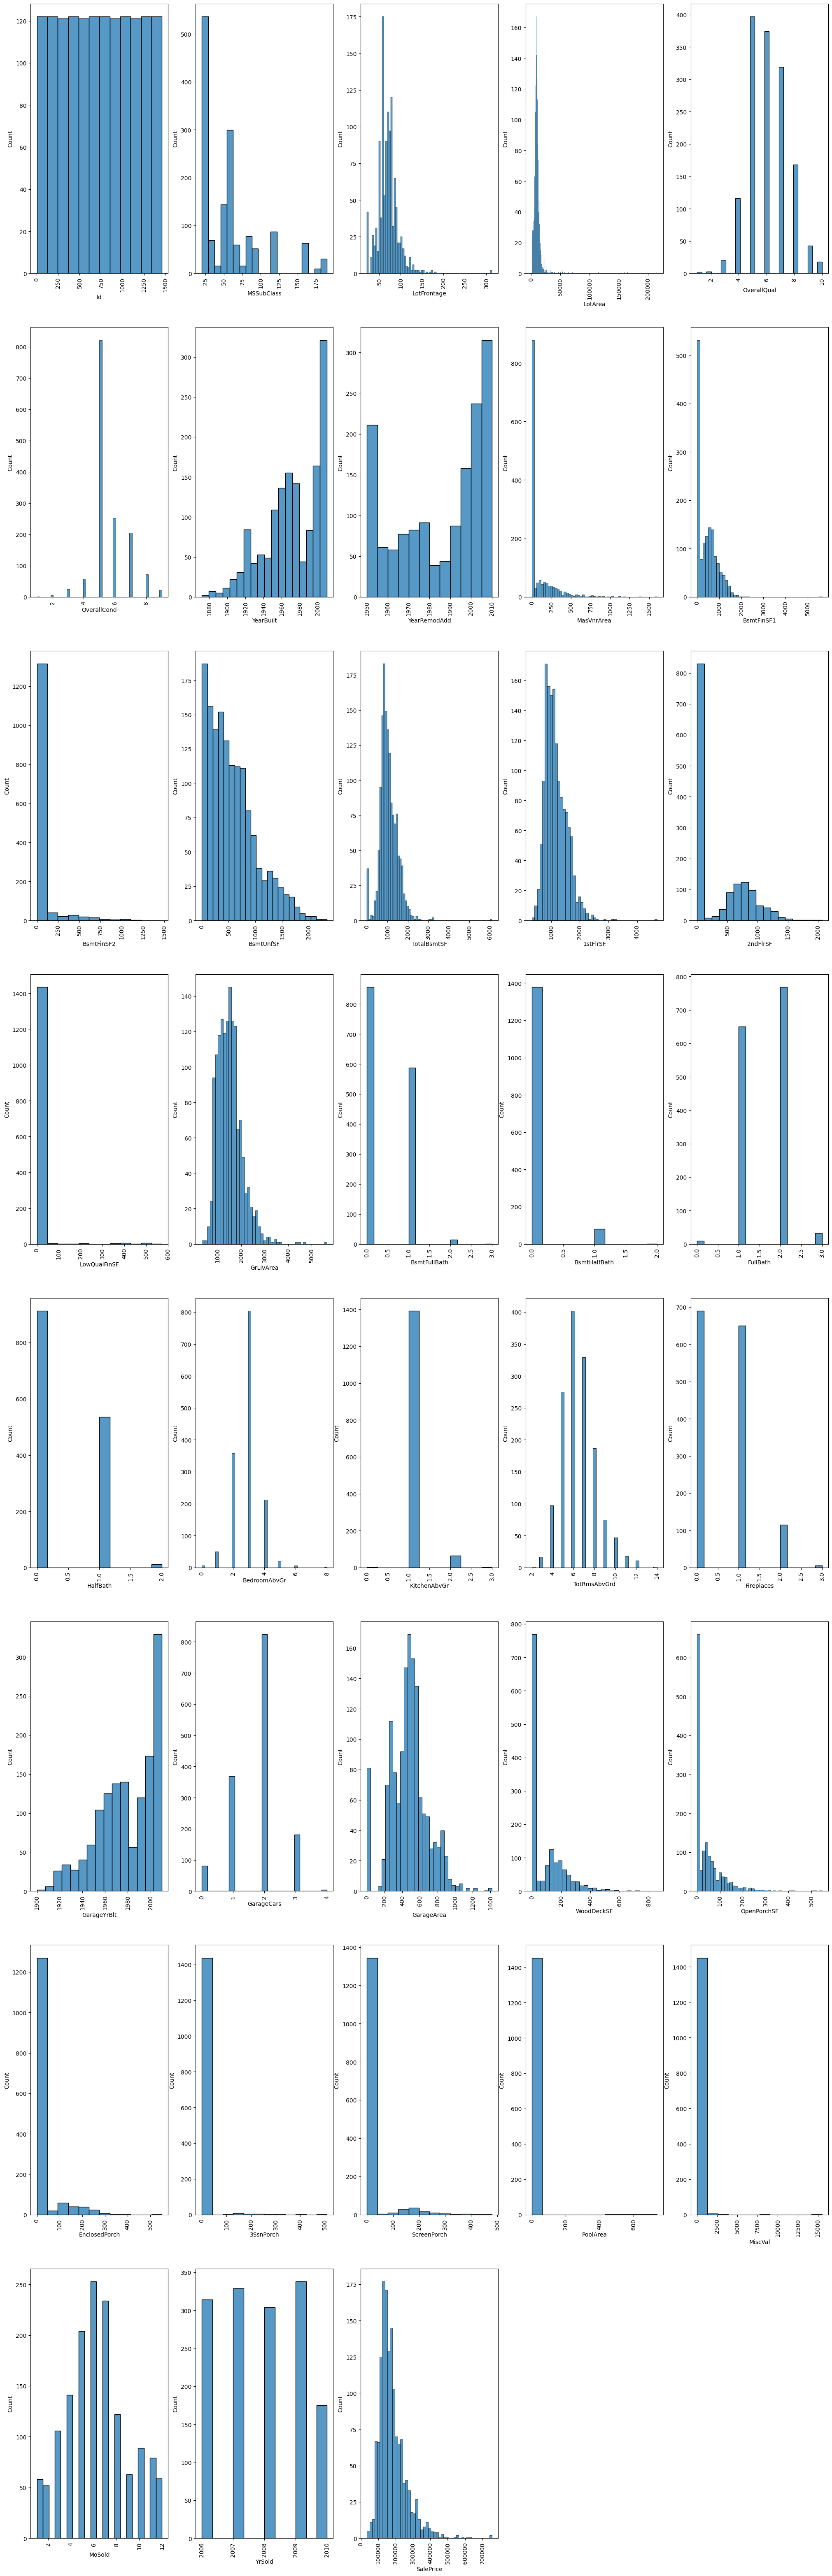

In [87]:
num_cols = len(df.columns[df.dtypes != 'object'])
num_rows = (num_cols // 5) + 1

plt.figure(figsize=(25, num_rows * 10))
for i, col in enumerate(df.columns[df.dtypes != 'object']):
    plt.subplot(num_rows, 5, i+1)
    sns.histplot(df[col].dropna())
    plt.xticks(rotation=90)

Columns which have almost zero values will be dropped 
- 3SsnPorch
- ScreenPorch
- PoolArea
- MiscVal

In [143]:
df1, y = data_preprocessing(df)

/var/folders/77/l0m4syw9301bj1fcnkqk75fr0000gn/T/ipykernel_66304/3325293674.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['MasVnrType'].fillna('None', inplace=True)
/var/folders/77/l0m4syw9301bj1fcnkqk75fr0000gn/T/ipykernel_66304/3325293674.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [160]:
numerical_columns = df.columns[df.dtypes != 'object']

In [161]:
numerical_columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

<Axes: >

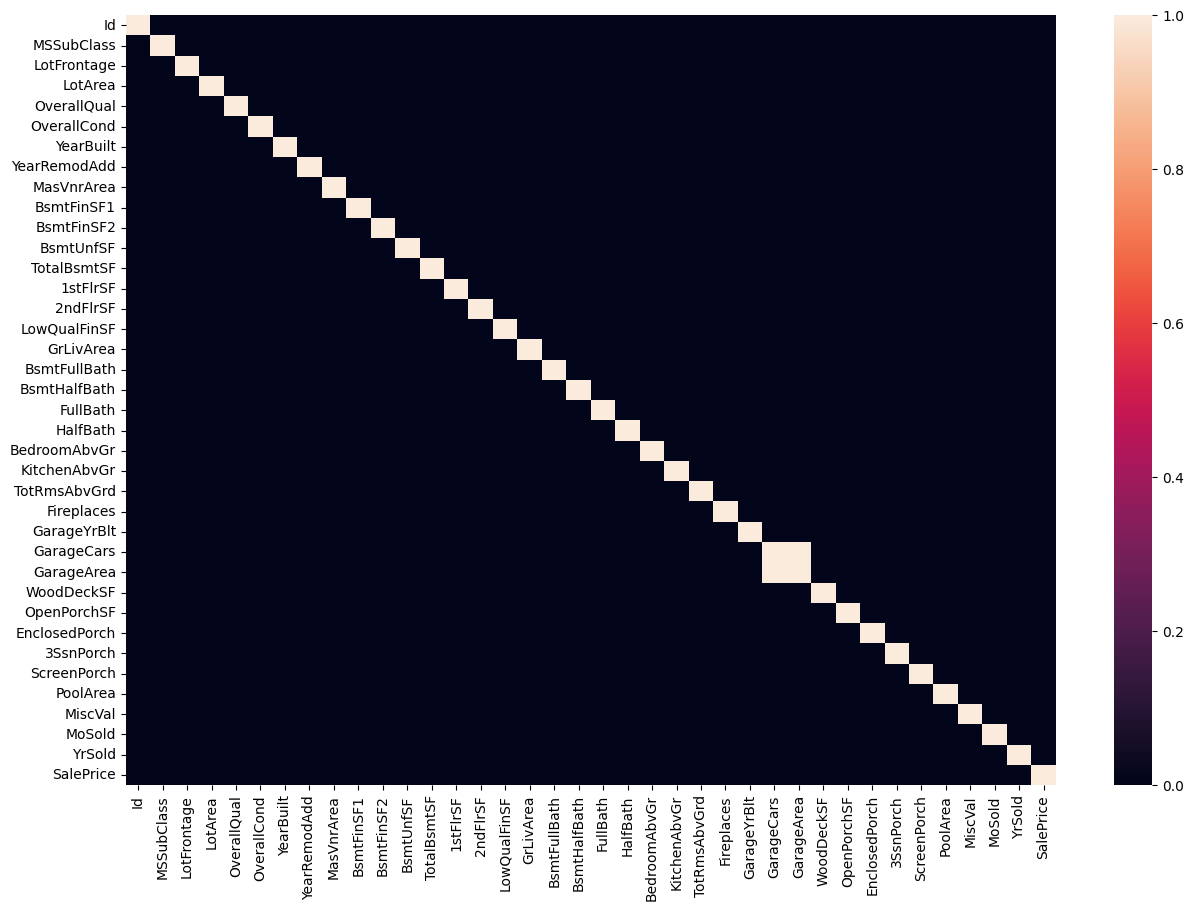

In [168]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[numerical_columns].corr() > 0.85, annot=False, fmt=".2f")

The columns GarageCars and GarageArea have high correlation, so drop Drop GarageArea